In [1]:
from torch_geometric.datasets import BA2MotifDataset
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import pandas as pd
import torch
import random
from torch_geometric.nn import GIN

### SAMPLE DATASET ###

In [2]:
dataset = BA2MotifDataset(root='data/BA2Motif')
dataset = dataset.shuffle()

In [3]:
data = dataset[525] 

/Users/admin/Documents/Screenshots/LORE/.env/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


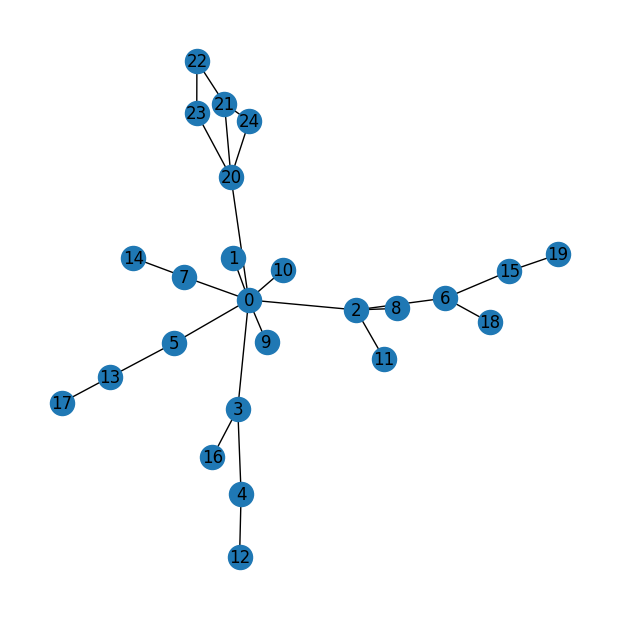

In [4]:
G = to_networkx(data, to_undirected=True)

plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, cmap="coolwarm", node_size=300)
plt.show()

In [5]:
import pandas as pd
import numpy as np
def extract_graph_features(data):
    num_nodes = data.num_nodes
    num_edges = data.num_edges
    avg_degree = 2 * num_edges / num_nodes
    # Tính trung bình của các đặc trưng nút nếu có
    if data.x is not None:
        node_feature_mean = data.x.mean(dim=0).numpy()
    else:
        node_feature_mean = np.zeros(10)  # Giả sử vector đặc trưng có 10 chiều
    return [num_nodes, num_edges, avg_degree] + node_feature_mean.tolist()

features = []
labels = []
for data in dataset:
    features.append(extract_graph_features(data))
    labels.append(data.y.item())
    
columns = ['num_nodes', 'num_edges', 'avg_degree'] + [f'feature_{i}' for i in range(10)]
df = pd.DataFrame(features, columns=columns)
df['y'] = labels
df_0 = df[df['y'] == 0]
df_1 = df[df['y'] == 1]

<function matplotlib.pyplot.show(close=None, block=None)>

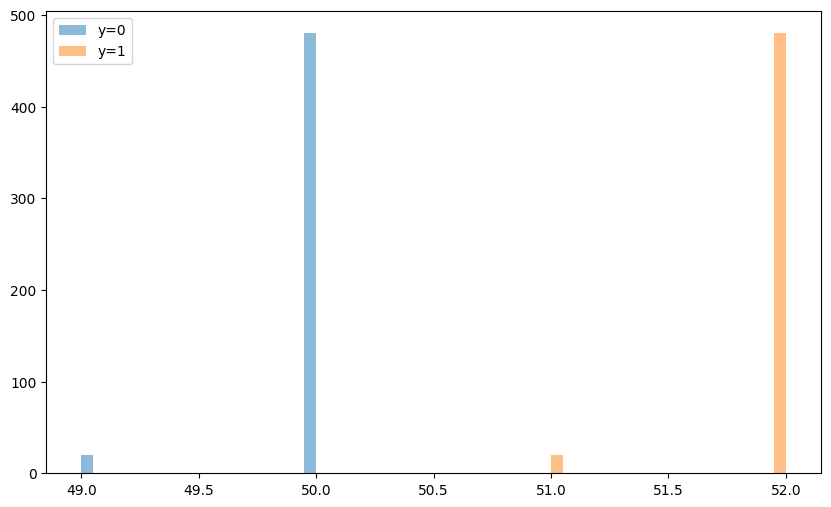

In [6]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df_0['num_edges'], bins=20, alpha=0.5, label='y=0')
plt.hist(df_1['num_edges'], bins=20, alpha=0.5, label='y=1')
plt.legend()
plt.show

/Users/admin/Documents/Screenshots/LORE/.env/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


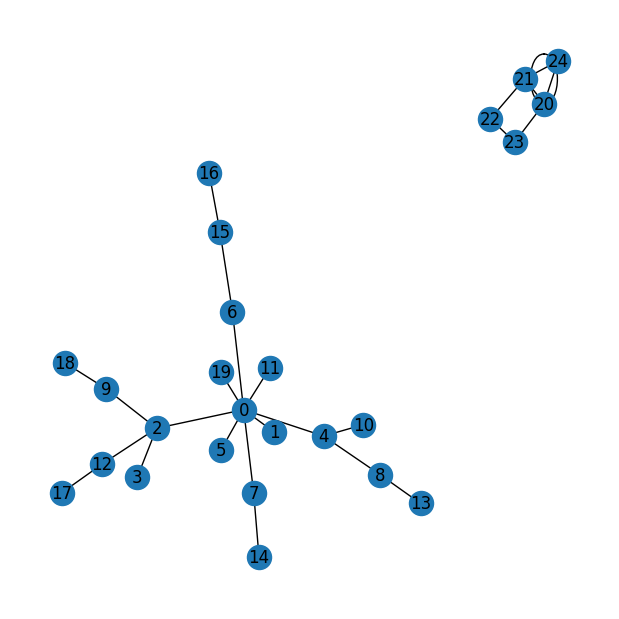

In [7]:
for graph in dataset:
    if (graph.num_edges == 51):
        G = to_networkx(graph, to_undirected=True)

        plt.figure(figsize=(6, 6))
        nx.draw(G, with_labels=True, cmap="coolwarm", node_size=300)
        plt.show()
        break

### TRAINING GIN ###

In [3]:
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GIN
import torch
import torch.nn.functional as F
from torch.nn import BatchNorm1d
from torch.nn import Linear, ReLU, Sequential
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.nn import global_mean_pool, global_max_pool

train_dataset, test_dataset, val_dataset = dataset[:800], dataset[800:900], dataset[900:]
print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

Training set   = 800 graphs
Validation set = 100 graphs
Test set       = 100 graphs


In [4]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.nn.models import MLP

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.utils import to_undirected

class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()

        # Các lớp GINConv với MLP
        for _ in range(num_layers):
            mlp = nn.Sequential(
                nn.Linear(in_channels, 2 * hidden_channels),
                nn.BatchNorm1d(2 * hidden_channels),  # Thêm BatchNorm sau mỗi lớp Linear
                nn.ReLU(),
                nn.Linear(2 * hidden_channels, hidden_channels),
            )
            conv = GINConv(mlp, train_eps=True)  # Kích hoạt train_eps để học giá trị eps
            self.convs.append(conv)
            self.batch_norms.append(nn.BatchNorm1d(hidden_channels))  # BatchNorm cho các đầu ra từ conv

            in_channels = hidden_channels  # Cập nhật in_channels cho lớp tiếp theo

        # MLP cuối cùng để tính toán kết quả phân loại
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.BatchNorm1d(hidden_channels),  # BatchNorm ở đây giúp cải thiện quá trình huấn luyện
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout để tránh overfitting
            nn.Linear(hidden_channels, out_channels),
        )

    def forward(self, x, edge_index, batch, batch_size, return_embeddings=False):
        # Chạy qua từng lớp GINConv và BatchNorm
        for conv, batch_norm in zip(self.convs, self.batch_norms):
            x = conv(x, edge_index)
            x = batch_norm(x).relu()  # Áp dụng BatchNorm và ReLU

        # Gom nhóm các node embeddings bằng global_add_pool (hoặc có thể là global_mean_pool, global_max_pool)
        node_embeddings = x  # Các embedding của node sau khi qua các GINConv
        graph_embedding = global_add_pool(x, batch, size=batch_size)
        
        # Kết quả phân loại từ MLP cuối cùng
        output = self.mlp(graph_embedding)
        
        if return_embeddings:
            return output, node_embeddings, graph_embedding
        
        return output




In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GIN(
    in_channels=dataset.num_features,
    hidden_channels=32,
    out_channels=dataset.num_classes,
    num_layers=5,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [6]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch, data.batch_size)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(loader):
    model.eval()
    total_correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch, data.batch_size)
        pred = out.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
    return total_correct / len(loader.dataset)

def predict(model, data_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            output = model(data.x, data.edge_index, data.batch, batch_size=data.num_graphs)
            predictions.append(output.cpu())
    
    return torch.cat(predictions, dim=0)


@torch.no_grad()
def get_node_embeddings(loader):
    model.eval()
    all_embeddings = []
    for data in loader:
        data = data.to(device)
        _, node_embeddings = model(data.x, data.edge_index, data.batch, data.batch_size, return_embeddings=True)
        all_embeddings.append(node_embeddings.cpu())
    return torch.cat(all_embeddings, dim=0)

In [7]:
import time
times = []
for epoch in range(1, 101):
    start = time.time()
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    times.append(time.time() - start)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Test: {test_acc:.4f}')
print(f'Median time per epoch: {torch.tensor(times).median():.4f}s')

Epoch: 001, Loss: 0.2761, Train: 0.4925, Test: 0.5000
Epoch: 002, Loss: 0.0207, Train: 0.9975, Test: 0.9900
Epoch: 003, Loss: 0.0477, Train: 1.0000, Test: 1.0000
Epoch: 004, Loss: 0.0067, Train: 1.0000, Test: 1.0000
Epoch: 005, Loss: 0.0038, Train: 1.0000, Test: 1.0000
Epoch: 006, Loss: 0.0021, Train: 1.0000, Test: 1.0000
Epoch: 007, Loss: 0.0013, Train: 1.0000, Test: 1.0000
Epoch: 008, Loss: 0.0024, Train: 1.0000, Test: 1.0000
Epoch: 009, Loss: 0.0018, Train: 1.0000, Test: 1.0000
Epoch: 010, Loss: 0.0008, Train: 1.0000, Test: 1.0000
Epoch: 011, Loss: 0.0008, Train: 1.0000, Test: 1.0000
Epoch: 012, Loss: 0.0006, Train: 1.0000, Test: 1.0000
Epoch: 013, Loss: 0.0005, Train: 1.0000, Test: 1.0000
Epoch: 014, Loss: 0.0003, Train: 1.0000, Test: 1.0000
Epoch: 015, Loss: 0.0005, Train: 1.0000, Test: 1.0000
Epoch: 016, Loss: 0.0006, Train: 1.0000, Test: 1.0000
Epoch: 017, Loss: 0.0006, Train: 1.0000, Test: 1.0000
Epoch: 018, Loss: 0.0005, Train: 1.0000, Test: 1.0000
Epoch: 019, Loss: 0.0004, Tr

In [8]:
# save model
torch.save(model.state_dict(), 'model/model.pth')

tensor([[ 0,  0,  0,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  4,  5,  5,  6,
          7,  8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 13, 14, 14, 15, 16,
         17, 18, 19, 20, 20, 20, 20, 21, 21, 21, 22, 22, 23, 23, 24, 24],
        [ 1,  3, 20,  0,  2,  1,  4,  5,  6,  7, 12, 14, 17,  0,  2,  2,  8,  2,
          2,  5,  9, 18,  8, 10, 11,  9, 19,  9, 16,  2, 13, 12,  2, 15, 14, 11,
          2,  8, 10,  0, 21, 23, 24, 20, 22, 24, 21, 23, 20, 22, 20, 21]])
tensor([[ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,
          2,  3,  4,  5,  6,  6,  7,  8,  9, 10, 11, 11, 12, 13, 13, 14, 15, 16,
         17, 18, 19, 20, 20, 20, 20, 21, 21, 21, 22, 22, 23, 23, 24, 24],
        [ 1,  2,  4,  5, 15, 20,  0,  6, 10, 11, 16, 17, 18, 19,  0,  3,  7,  8,
          9,  2,  0,  0,  1, 12,  2,  2,  2,  1,  1, 13,  6, 11, 14, 13,  0,  1,
          1,  1,  1,  0, 21, 23, 24, 20, 22, 24, 21, 23, 20, 22, 20, 21]])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  

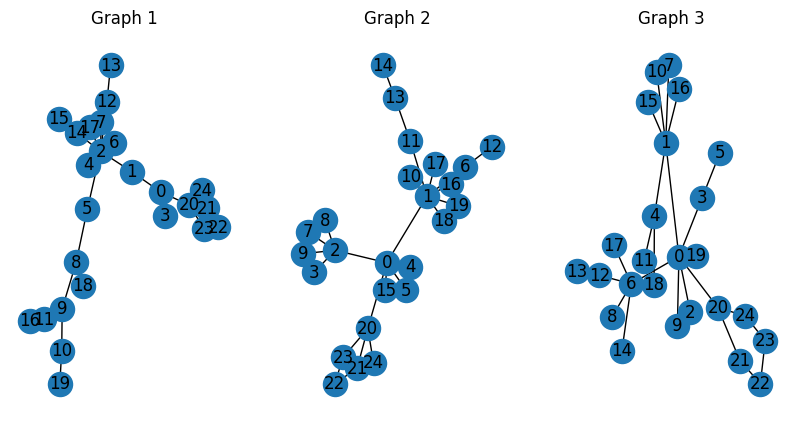

In [14]:
batch = next(iter(test_loader)) 
edge_index = batch.edge_index
ptr = batch.ptr  
num_graphs = len(ptr) - 1 

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for i in range(3):  # Lặp qua 2 đồ thị đầu tiên
    start, end = ptr[i].item(), ptr[i + 1].item()  # Lấy phạm vi node của đồ thị
    mask = (batch.batch == i)  # Chọn node thuộc về đồ thị i

    # Lấy subgraph từ batch
    subgraph = batch.clone()
    subgraph.x = batch.x[mask]
    subgraph.edge_index = edge_index[:, (edge_index[0] >= start) & (edge_index[0] < end)] - start
    print(subgraph.edge_index)
    # Chuyển thành NetworkX để vẽ
    G = to_networkx(subgraph, to_undirected=True)

    # Vẽ đồ thị
    ax = axes[i]
    #nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', ax=ax)
    nx.draw(G, with_labels=True, cmap="coolwarm", node_size=300, ax=ax)
    ax.set_title(f"Graph {i+1}")

plt.show()

In [9]:
from sklearn.metrics import classification_report

gin = GIN(
    in_channels=dataset.num_features,
    hidden_channels=32,
    out_channels=dataset.num_classes,
    num_layers=5,
).to(device)
gin.load_state_dict(torch.load('model/model.pth'))
gin.eval()

data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
predictions = predict(gin, data_loader, device)


y_true = [data.y.item() for data in test_dataset]
y_pred = predictions.argmax(dim=-1).numpy()
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [30]:
import torch
import pandas as pd

@torch.no_grad()
def get_mean_node_embeddings_df(loader):
    model.eval()
    all_graphs = []  
    labels = []
    edge_dicts = []

    for data in loader:
        data = data.to(device)
        _, node_embeddings = model(data.x, data.edge_index, data.batch, data.batch_size, return_embeddings=True)

        num_graphs = data.batch_size
        for i in range(num_graphs):
            mask = (data.batch == i)  
            mean_node_embedding = node_embeddings[mask].mean(dim=0).cpu().numpy()  
            
            labels.append(data.y[i].item())
            all_graphs.append(mean_node_embedding.flatten().tolist())

            # Lấy danh sách cạnh của đồ thị thứ i
            edge_mask = (data.batch[data.edge_index[0]] == i)  # Chỉ lấy cạnh thuộc đồ thị i
            graph_edges = data.edge_index[:, edge_mask].cpu().numpy().T.tolist()
            
            edge_dicts.append({f'node{e1}_node{e2}': 1 for e1, e2 in graph_edges})  # Lưu cạnh dưới dạng dict

    # Tạo DataFrame từ embeddings
    max_nodes = max(len(graph) for graph in all_graphs)
    embed_columns = [f'node_embed_{i+1}' for i in range(max_nodes)]
    df = pd.DataFrame(all_graphs, columns=embed_columns)
    
    # Tạo DataFrame từ danh sách cạnh
    df_edges = pd.DataFrame(edge_dicts).fillna(0)  # Chuyển None thành 0

    # Gộp hai DataFrame lại
    df = pd.concat([df, df_edges], axis=1)
    df['y'] = labels  # Thêm nhãn

    return df

# Gọi hàm để lấy DataFrame
df_node_embeddings = get_mean_node_embeddings_df(test_loader)
df_node_embeddings[:10]


,node_embed_1,node_embed_2,node_embed_3,node_embed_4,node_embed_5,node_embed_6,node_embed_7,node_embed_8,node_embed_9,node_embed_10,...,node89_node93,node91_node79,node92_node79,node93_node89,node94_node78,node95_node98,node96_node99,node98_node95,node99_node96,y
0,0.0,0.000000,0.344933,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.000000,0.229729,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.000000,0.154091,0.0,0.0,0.0,0.0,0.950291,1.271255,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.001528,0.117899,0.0,0.0,0.0,0.0,1.528940,2.012563,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.000000,0.305307,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,0.0,0.000000,0.206603,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,0.0,0.000000,0.334949,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0.0,0.000000,0.172003,0.0,0.0,0.0,0.0,0.949422,1.277529,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,0.0,0.000000,0.331737,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,0.0,0.000000,0.178687,0.0,0.0,0.0,0.0,0.924530,1.259266,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [17]:
# convert to numpy array
X = df_node_embeddings.drop(columns='y').values
y = df_node_embeddings['y'].values
X

array([[0.03170988, 0.03471569, 0.03034792, ..., 0.14253473, 0.11202688,
        0.10396838],
       [0.04587548, 0.02713773, 0.0268891 , ..., 0.14751333, 0.14198685,
        0.14132854],
       [0.03777606, 0.02987847, 0.03111407, ..., 1.38130999, 1.38130999,
        0.87313521],
       ...,
       [0.02370143, 0.0205092 , 0.022427  , ..., 0.14761674, 0.14692216,
        0.14648752],
       [0.03315566, 0.02422336, 0.04877609, ..., 1.38280308, 1.38280308,
        0.87925589],
       [0.02300642, 0.08105694, 0.08513284, ..., 0.14739737, 0.13875833,
        0.1379368 ]], shape=(100, 25))

In [18]:
import torch
from torch_geometric.data import Batch

@torch.no_grad()
def predict_single_graph(model, graph, device):
    model.eval()
    
    # Tạo batch giả (dù chỉ có 1 graph)
    graph.batch = torch.zeros(graph.x.size(0), dtype=torch.long)  # Tất cả node thuộc batch 0
    batch = Batch.from_data_list([graph]).to(device)

    # Forward qua mô hình
    out = model(batch.x, batch.edge_index, batch.batch, batch_size=1)
    
    # Lấy nhãn dự đoán
    predicted_label = out.argmax(dim=-1).item()
    
    return predicted_label

# Lấy graph thứ 0 từ test_dataset
graph = test_dataset[:20]
print(graph)
for i in range(20):
    predicted_label = predict_single_graph(gin, graph[i], device)
    print(f'Predicted label: {predicted_label}, True label: {graph[i].y.item()}')

BA2MotifDataset(20)
Predicted label: 1, True label: 1
Predicted label: 1, True label: 1
Predicted label: 0, True label: 0
Predicted label: 0, True label: 0
Predicted label: 1, True label: 1
Predicted label: 1, True label: 1
Predicted label: 1, True label: 1
Predicted label: 0, True label: 0
Predicted label: 1, True label: 1
Predicted label: 0, True label: 0
Predicted label: 1, True label: 1
Predicted label: 1, True label: 1
Predicted label: 0, True label: 0
Predicted label: 0, True label: 0
Predicted label: 0, True label: 0
Predicted label: 0, True label: 0
Predicted label: 0, True label: 0
Predicted label: 1, True label: 1
Predicted label: 1, True label: 1
Predicted label: 0, True label: 0


In [19]:
def predict(model, data_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            output = model(data.x, data.edge_index, data.batch, batch_size=data.num_graphs)
            predictions.append(output.cpu())
    
    return torch.cat(predictions, dim=0)

labels = [data.y.item() for data in test_dataset]
predictions = predict(gin, test_loader, device)
predictions = predictions.argmax(dim=-1).numpy()    
print(predictions)

[1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 0
 0 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1]


In [20]:
y = [random.randint(0, 1) for _ in range(1000)]
y = torch.tensor(y).numpy()
print(y)

[1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1 0
 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 0
 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1
 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0
 1 1 0 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1
 1 0 1 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0
 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1
 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 1
 0 1 1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 1 0
 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 1 0 0
 1 1 1 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0
 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1
 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 1 0 0 1
 0 1 1 0 1 1 0 0 1 1 0 1 

In [21]:
import torch
from torch_geometric.nn import global_add_pool

@torch.no_grad()
def get_graph_embeddings(loader, model, device):
    model.eval()
    all_graph_embeddings = []  # Danh sách lưu graph embedding của từng đồ thị

    for data in loader:
        data = data.to(device)
        
        # Lấy node embeddings từ model
        _, node_embeddings = model(data.x, data.edge_index, data.batch, data.batch_size, return_embeddings=True)
        
        # Tính graph embedding bằng global_add_pool
        graph_embeddings = global_add_pool(node_embeddings, data.batch, size=data.batch_size)

        all_graph_embeddings.append(graph_embeddings.cpu())  # Chuyển về CPU để xử lý dễ dàng

    return torch.cat(all_graph_embeddings, dim=0)  # Ghép tất cả embeddings lại


In [22]:
graph_embeddings = get_graph_embeddings(test_loader, gin, device)
graph_embeddings

tensor([[ 0.0000,  0.0000,  8.6233,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  5.7432,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  3.8523,  ..., 36.9187,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  7.7773,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  4.7336,  ..., 37.0627,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.1869,  ...,  0.0000,  0.0000,  0.0000]])

In [23]:
@torch.no_grad()
def get_mean_node_embeddings_df(loader):
    model.eval()
    all_graphs = []  
    labels = []
    mean_feature_vectors = []
    global_poolings = []
    
    for data in loader:
        data = data.to(device)
        _, node_embeddings = model(data.x, data.edge_index, data.batch, data.batch_size, return_embeddings=True)
        
        num_graphs = data.batch_size
        for i in range(num_graphs):
            mask = (data.batch == i)  
            mean_node_embedding = node_embeddings[mask].mean(dim=0).cpu().numpy()  # Mean over all nodes
            sum_node_embedding = node_embeddings[mask].sum(dim=0).cpu().numpy()   # Sum pooling
            mean_feature_vector = data.x[mask].mean(dim=0).cpu().numpy()
            
            labels.append(data.y[i].item())
            all_graphs.append(mean_node_embedding.flatten().tolist())
            mean_feature_vectors.append(mean_feature_vector.tolist())
            global_poolings.append(sum_node_embedding.flatten().tolist())
    
    max_nodes = max(len(graph) for graph in all_graphs)
    padded_graphs = [list(graph) + [None] * (max_nodes - len(graph)) for graph in all_graphs]
    columns = [f'n_embed{i}' for i in range(max_nodes)]
    
    df = pd.DataFrame(padded_graphs, columns=columns)
    df['y'] = labels
    
    # mean_feature_columns = [f'feature_mean_{i}' for i in range(len(mean_feature_vectors[0]))]
    # df_mean_features = pd.DataFrame(mean_feature_vectors, columns=mean_feature_columns)
    
    # sum_embedding_columns = [f'sum_embedding_{i}' for i in range(len(global_poolings[0]))]
    # df_sum_embeddings = pd.DataFrame(global_poolings, columns=sum_embedding_columns)
    
    df = pd.concat([df], axis=1)
    return df

df = get_mean_node_embeddings_df(test_loader)
df.columns
df[:10]

,n_embed0,n_embed1,n_embed2,n_embed3,n_embed4,n_embed5,n_embed6,n_embed7,n_embed8,n_embed9,...,n_embed23,n_embed24,n_embed25,n_embed26,n_embed27,n_embed28,n_embed29,n_embed30,n_embed31,y
0,0.0,0.000000,0.344933,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1
1,0.0,0.000000,0.229729,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1
2,0.0,0.000000,0.154091,0.0,0.0,0.0,0.0,0.950291,1.271255,0.0,...,0.0,0.0,0.0,0.0,0.968788,0.0,1.476750,0.0,0.0,0
3,0.0,0.001528,0.117899,0.0,0.0,0.0,0.0,1.528940,2.012563,0.0,...,0.0,0.0,0.0,0.0,1.561884,0.0,2.302991,0.0,0.0,0
4,0.0,0.000000,0.305307,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1
5,0.0,0.000000,0.206603,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1
6,0.0,0.000000,0.334949,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1
7,0.0,0.000000,0.172003,0.0,0.0,0.0,0.0,0.949422,1.277529,0.0,...,0.0,0.0,0.0,0.0,0.973636,0.0,1.486100,0.0,0.0,0
8,0.0,0.000000,0.331737,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1
9,0.0,0.000000,0.178687,0.0,0.0,0.0,0.0,0.924530,1.259266,0.0,...,0.0,0.0,0.0,0.0,0.958372,0.0,1.474138,0.0,0.0,0


In [24]:
import torch

@torch.no_grad()
def predict_graph_labels(model, loader, device):
    model.eval()
    predictions = []

    for data in loader:
        data = data.to(device)
        _, node_embeddings = model(data.x, data.edge_index, data.batch, data.batch_size, return_embeddings=True)

        # Tính mean node embedding cho từng graph
        num_graphs = data.batch_size
        mean_embeddings = []
        for i in range(num_graphs):
            mask = (data.batch == i)
            mean_embedding = node_embeddings[mask].mean(dim=0)  # Mean theo chiều 0
            mean_embeddings.append(mean_embedding)

        mean_embeddings = torch.stack(mean_embeddings)  # Chuyển thành tensor

        # Dự đoán label từ mean embedding qua MLP
        output = model.mlp(mean_embeddings)  # Dùng MLP classifier
        predicted_labels = output.argmax(dim=1).cpu().tolist()
        predictions.extend(predicted_labels)

    return predictions

predictions = predict_graph_labels(gin, test_loader, device)
predictions

[1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1]

In [25]:
import torch
import numpy as np

@torch.no_grad()
def get_graph_info_array(model, device, loader):
    model.eval()
    
    graph_info_list = []
    
    for data in loader:
        data = data.to(device)
        _, node_embeddings = model(data.x, data.edge_index, data.batch, data.batch_size, return_embeddings=True)
        
        num_graphs = data.batch_size
        for i in range(num_graphs):
            mask = (data.batch == i)  
            # mean_node_embedding = node_embeddings[mask].mean(dim=0).cpu().numpy()  # Mean pooling
            # sum_node_embedding = node_embeddings[mask].sum(dim=0).cpu().numpy()   # Sum pooling
            # mean_feature_vector = data.x[mask].mean(dim=0).cpu().numpy()
            
            # Lưu thông tin của từng graph dưới dạng dictionary
            graph_info = {
                # "mean_node_embedding": mean_node_embedding,
                # "mean_feature_vector": mean_feature_vector,
                # "sum_pooling": sum_node_embedding,
                "x": data.x[mask].cpu().numpy(),  # Node features
                "edge_index": data.edge_index.cpu().numpy(),  # Edge list
                "y": data.y[i].item()  # Label
            }
            
            graph_info_list.append(graph_info)
    
    # Chuyển thành numpy array
    graph_info_array = np.array(graph_info_list, dtype=object)  
    return graph_info_array

graph_info_array = get_graph_info_array(gin, device, test_loader)
graph = graph_info_array[0]
edge_index = graph['edge_index']
edge_index

array([[  0,   0,   0, ..., 798, 799, 799],
       [  1,   3,  20, ..., 799, 795, 798]], shape=(2, 1633))

Node features shape: (25, 10)
Edge index shape: (2, 50)
Label: 0


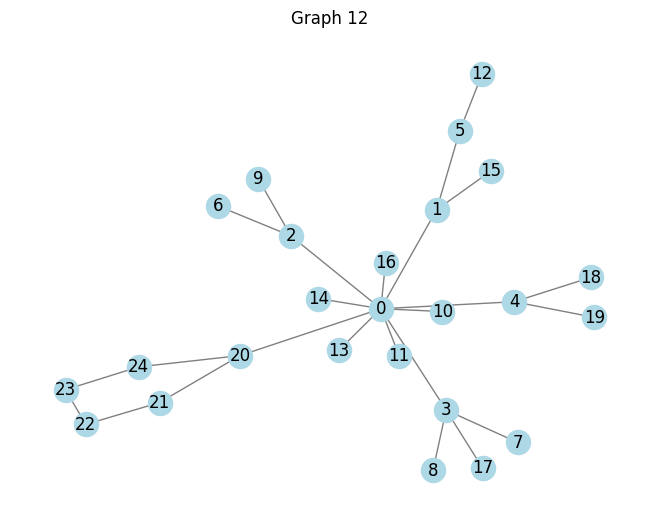

In [26]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

@torch.no_grad()
def extract_graph_info(loader):
    graph_info_array = []
    
    for batch in loader:
        edge_index = batch.edge_index
        ptr = batch.ptr  
        num_graphs = len(ptr) - 1 
        
        for i in range(num_graphs):
            start, end = ptr[i].item(), ptr[i + 1].item()  
            mask = (batch.batch == i) 
            
            node_features = batch.x[mask].cpu().numpy()
    
            sub_edge_index = edge_index[:, (edge_index[0] >= start) & (edge_index[0] < end)] - start
            sub_edge_index = sub_edge_index.cpu().numpy()
            label = batch.y[i].item()
            
            graph_info = {
                "x": node_features,
                "edge_index": sub_edge_index,
                "y": label,
            }
            graph_info_array.append(graph_info)
    
    return graph_info_array

graph_info_array = extract_graph_info(test_loader)

graph = graph_info_array[83]
print("Node features shape:", graph["x"].shape)
print("Edge index shape:", graph["edge_index"].shape)
print("Label:", graph["y"])

G = nx.Graph()
G.add_edges_from(graph["edge_index"].T)
nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray")
plt.title("Graph 12")
plt.show()


In [27]:
import torch

@torch.no_grad()
def predict_graph(model, device, graph_info):
    model.eval()
    node_features = torch.tensor(graph_info["x"], dtype=torch.float32, device=device)
    edge_index = torch.tensor(graph_info["edge_index"], dtype=torch.long, device=device)

    batch = torch.zeros(node_features.shape[0], dtype=torch.long, device=device)
    
    # Forward qua model
    output = model(node_features, edge_index, batch, batch_size=1)
    
    # Lấy nhãn dự đoán
    predictions = output.argmax(dim=-1)  # Trả về tensor có nhiều giá trị
    return predictions.numpy().reshape(1)


graph = extract_graph_info(test_loader)[88]
predicted_label = predict_graph(gin, device, graph)
predicted_label

array([0])